# Nomura Quant Project Submission 
* To design and test quantitative mean reverting strategies. 


### import libs

In [15]:
# pip install quantstats

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
%matplotlib inline
plt.style.use('fivethirtyeight')
import quantstats as qs


The data file was larger than what github accepts. Kindly download it from here https://drive.google.com/file/d/1ZanTWpVlG7YaOm_wRv_fPvrs46SaWE_I/view?usp=sharing

In [17]:
#importing clean data from data_download notebook
import pickle
with open("data_final.pkl", "rb") as f:
  data_final = pickle.load(f)
data_final.set_index(['time'],inplace=True) 

data_final  

,date,code,open,high,low,close,volume,amount,adjustflag
time,,,,,,,,,
20220401100000000,2022-04-01,sh.600006,5.45,5.45,5.40,5.43,2019505.0,10960302.0000,3
20220401103000000,2022-04-01,sh.600006,5.43,5.47,5.43,5.46,983100.0,5359361.0000,3
20220401110000000,2022-04-01,sh.600006,5.46,5.48,5.43,5.46,854700.0,4667252.0000,3
20220401113000000,2022-04-01,sh.600006,5.46,5.47,5.44,5.44,712300.0,3887314.0000,3
20220401133000000,2022-04-01,sh.600006,5.44,5.45,5.43,5.43,481100.0,2616551.0000,3
...,...,...,...,...,...,...,...,...,...
20220729113000000,2022-07-29,sz.300699,70.34,70.69,70.00,70.07,553807.0,38977724.0000,3
20220729133000000,2022-07-29,sz.300699,70.03,70.03,69.30,69.60,432687.0,30084125.0000,3
20220729140000000,2022-07-29,sz.300699,69.70,69.96,69.60,69.75,243000.0,16955343.0000,3


## Create features
### Feature 1

* The idea is to calculate rolling mean. Then calculate a lower and upper band around it. Which would be made of +2 std dev and -2 std dev of prices
* If prices fall below -2 Stddev it means its bound to revert up to mean. this is a buy signal
* If prices go above +2 Stddev it means its bound to revert down to mean. this is a sell signal

### Feature 2 
* Exponential moving average. 
* Exponential average will give more weightage to recent value than past values


### Feature 3
* Our 3rd feature is VWAP - volume weighted average price and +/2 StdDev bands around it
* VWAP capturs market sentiment by including the volume traded for the given price

In [18]:
window = 8

def upper_band(group,mean,window):
    return group[mean] + group['close'].rolling(window).std()*2
def lower_band(group,mean,window):
    return group[mean] - group['close'].rolling(window).std()*2



#Feature 1
group_data = data_final.groupby('code')
data_final['sma_mean'] =  group_data['close'].rolling(window).mean().reset_index(level=0, drop = True)
data_final['sma_upper_band'] = group_data.apply(lambda group: upper_band(group,'sma_mean',window)).reset_index(level =0, drop =True)
data_final['sma_lower_band'] = group_data.apply(lambda group: lower_band(group,'sma_mean',window)).reset_index(level =0, drop =True)

#Feature 2
data_final['ema_mean'] =  group_data['close'].apply(lambda group : group.ewm(span=window,adjust = False).mean()).reset_index(level=0, drop = True)
data_final['ema_upper_band'] = group_data.apply(lambda group: upper_band(group,'ema_mean',window)).reset_index(level = 0 , drop = True)
data_final['ema_lower_band'] = group_data.apply(lambda group: lower_band(group,'ema_mean',window)).reset_index(level = 0 , drop = True)

#Feature 3
data_final['volprice'] = group_data.apply(lambda group: ((group['close'] + group['low'] + group['high'])/3)*group['volume']).reset_index(level = 0 , drop = True)
data_final['volpricesum'] = group_data['volprice'].rolling(window).sum().reset_index(level = 0 , drop = True)
data_final['volsum'] = group_data['volume'].rolling(window).sum().reset_index(level = 0 , drop = True)
data_final['vwap'] = group_data.apply(lambda group: group['volpricesum'].divide(group['volsum'])).reset_index(level = 0 , drop = True)
data_final['vwap_upper_band'] = group_data.apply(lambda group: upper_band(group, 'vwap', window)).reset_index(level = 0 , drop = True)
data_final['vwap_lower_band'] = group_data.apply(lambda group: lower_band(group, 'vwap', window)).reset_index(level = 0 , drop = True)
data_final

,date,code,open,high,low,close,volume,amount,adjustflag,sma_mean,...,sma_lower_band,ema_mean,ema_upper_band,ema_lower_band,volprice,volpricesum,volsum,vwap,vwap_upper_band,vwap_lower_band
time,,,,,,,,,,,,,,,,,,,,,
20220401100000000,2022-04-01,sh.600006,5.45,5.45,5.40,5.43,2019505.0,10960302.0000,3,NaN,...,NaN,5.430000,NaN,NaN,1.095918e+07,NaN,NaN,NaN,NaN,NaN
20220401103000000,2022-04-01,sh.600006,5.43,5.47,5.43,5.46,983100.0,5359361.0000,3,NaN,...,NaN,5.436667,NaN,NaN,5.361172e+06,NaN,NaN,NaN,NaN,NaN
20220401110000000,2022-04-01,sh.600006,5.46,5.48,5.43,5.46,854700.0,4667252.0000,3,NaN,...,NaN,5.441852,NaN,NaN,4.663813e+06,NaN,NaN,NaN,NaN,NaN
20220401113000000,2022-04-01,sh.600006,5.46,5.47,5.44,5.44,712300.0,3887314.0000,3,NaN,...,NaN,5.441440,NaN,NaN,3.882035e+06,NaN,NaN,NaN,NaN,NaN
20220401133000000,2022-04-01,sh.600006,5.44,5.45,5.43,5.43,481100.0,2616551.0000,3,NaN,...,NaN,5.438898,NaN,NaN,2.615580e+06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220729113000000,2022-07-29,sz.300699,70.34,70.69,70.00,70.07,553807.0,38977724.0000,3,69.74625,...,68.940277,69.729506,70.535479,68.923533,3.890679e+07,3.450996e+08,4957747.0,69.608157,70.414131,68.802184
20220729133000000,2022-07-29,sz.300699,70.03,70.03,69.30,69.60,432687.0,30084125.0000,3,69.71875,...,68.909275,69.700727,70.510202,68.891252,3.013376e+07,3.401188e+08,4886034.0,69.610394,70.419869,68.800919
20220729140000000,2022-07-29,sz.300699,69.70,69.96,69.60,69.75,243000.0,16955343.0000,3,69.72250,...,68.912720,69.711677,70.521456,68.901897,1.695411e+07,3.317476e+08,4766034.0,69.606629,70.416409,68.796850


## Backtesting Code
* This code simulates buy/sell actions that would have occurred as per our features and our investing strategy
* Common code for all features
* Instructions- Everyday I put in 100 to buy a set of stocks. And the purchased stocks can be sold anytime in the future. 


In [19]:

def backtest(backtest_data,period,lowerband, upperband ):    
    total_amt_invested = []
    fund_value = []  # market value of stocks which we are holding
    cash_from_selling = [] #cash I get from selling doesn't go back into trading capital. So this is my earning
    periodic_trades = []  #a list of dataframes. Each dataframe stores all actions done and status after each period.
    daily_fund = 0  #daily fund which we have to make 100 at start of each day. 

    #stores qty of all stocks present at any given time
    live_stock_inventory = pd.DataFrame(index = backtest_data['code'].unique().tolist(),columns=['qty'] ) 
    live_stock_inventory['qty'] = 0

    for time in tqdm(period, desc='Backtesting Progress: '):

        #initialize funds  as per given day and period
        #special block for day 1
        if len(total_amt_invested) < 1:       
            daily_fund = 100
            total_amt_invested.append(100)
            cash_from_selling.append(0)
            
        else:
            # if new day has started, add 100
            if backtest_data.loc[time]['date'][0] != old_date: 
                daily_fund = 100
                total_amt_invested.append(total_amt_invested[-1] + 100)
                cash_from_selling.append(0)
                # fund_value.append(0)
                
            #new period started but not new day
            else:
                daily_fund = 0
                total_amt_invested.append(total_amt_invested[-1])
                cash_from_selling.append(0)
                # fund_value.append(0)


        #generate buy/sell signal for all stocks for current period
        periodic_df = backtest_data.loc[time].copy() #gets stock data for current period
        periodic_df.reset_index(inplace=True)
        periodic_df.set_index(['code'] , inplace = True )
        periodic_df['buy_signal'] = np.where(periodic_df['close'] <= periodic_df[lowerband], 1, 0)
        periodic_df['sell_signal'] = np.where(periodic_df['close'] > periodic_df[upperband], 1, 0)
        
        #buy signal
        if periodic_df['buy_signal'].sum()>=1 : 
            #buy signal + funds available. We buy
            if daily_fund ==100:
                        
                buy_stocks = periodic_df[periodic_df['buy_signal']==1][['close',lowerband]]
                #weighted distribution of funds. The stock further away from Lower_Band will get higher weight ( and more funds allocated)
                buy_stocks['abs_diff'] = (abs(buy_stocks['close'].sub( buy_stocks[lowerband]  ))) 
                buy_stocks['weight'] = buy_stocks['abs_diff'].div(    buy_stocks['abs_diff'].sum() ) 
                buy_stocks['fund_allocation'] = buy_stocks['weight'] * 100
                buy_stocks['buy_qty'] = buy_stocks['fund_allocation'].div(buy_stocks['close'])
                #stocks purchased. So update inventory
                live_stock_inventory['qty'] = live_stock_inventory['qty'].add(buy_stocks['buy_qty'],fill_value=0) 
            
            else:
                pass

        #sell signal
        if periodic_df['sell_signal'].sum()>=1:   
            #sell signal and stocks available in inventory. We sell. 
            if  live_stock_inventory['qty'].sum() > 0:
                
                sell_stocks = periodic_df[periodic_df['sell_signal']==1][['close']]

                #get qty present for stocks that have sell signals.
                sell_stocks  = pd.merge(sell_stocks, live_stock_inventory, left_index= True, right_index= True)
                
                #save earnings from selling stocks in a list
                cash_from_selling[-1] = np.dot(sell_stocks['close'],sell_stocks['qty'])
                
                #update stock inventory for stocks sold.
                for stock in sell_stocks.index.tolist():
                    if live_stock_inventory.loc[stock][0] > 0:
                        live_stock_inventory.loc[stock] =0 
            
            else:
                pass


        periodic_df['qty'] = live_stock_inventory['qty'] 
        periodic_df['market_value'] = periodic_df['close'].multiply ( periodic_df['qty'])
        periodic_trades.append(periodic_df)
        fund_value.append( (periodic_df['market_value'].sum() ))

        old_date = backtest_data.loc[time]['date'][0] 
        
    
    return fund_value, total_amt_invested, cash_from_selling, periodic_trades, live_stock_inventory 

## Calculating Returns for Each Period

Calculating period-wise returns when  1) we are actively investing 100 and 2) also selling shares 

In [20]:
def calculate_periodic_returns(backtest_results):
    periodic_return = []
    p = []
    t = []
    starting_index = backtest_results['fund_value'].tolist().index(100) + 1
    returns_index =  backtest_results.index[starting_index:]
    backtest_results['shift'] = backtest_results['total_amt_invested'] - backtest_results['total_amt_invested'].shift(1)

    #we cant calculate return when we first buy stocks worth 100(fund value 0->100 ). Because then we will be dividing by zero. Infinite results
    #so we start calculating on the very next day after purchasing stocks for the first time. Because then market value changes and we can calculate returns like 100->105, 5% return
    for i in range(starting_index,len(backtest_results)):

        previous = backtest_results.iloc[i-1]['fund_value']
        
        today =0
        #when new funds are added. Those funds are not returns from market. So that component needs to be substracted while computing the returns
        if backtest_results.iloc[i]['shift'] ==100:

            #when new funds are added + some stocks are sold. I need to include that cash from sellings. Its my earning from portfolio. Its a part of my fundvalue that I just withdrawn
            if backtest_results.iloc[i]['cash_from_selling'] > 0:

                today= backtest_results.iloc[i]['fund_value'] -100 + backtest_results.iloc[i]['cash_from_selling']
            
            #new funds + no selling stocks. Simply subtract 100 as that is not part of returns from market
            else:
                
                today = backtest_results.iloc[i]['fund_value']-100
        
        else:
            
            #no new funds + cash from selling stocks. Just add cashfrom selling stocks.
            if backtest_results.iloc[i]['cash_from_selling'] > 0:
                
                today = backtest_results.iloc[i]['fund_value'] +  backtest_results.iloc[i]['cash_from_selling']
            
            #no new funds + no selling stocks. Do nothing
            else:    
                
                today =  backtest_results.iloc[i]['fund_value']

        periodic_return.append(((today-previous)/previous)) 
        p.append(previous)
        t.append(today)       

    periodic_returns = pd.DataFrame({'periodic_R': periodic_return,
                                'p':p,
                                't':t}, index= returns_index)
    periodic_returns.index.name = 'time'
    
    return periodic_returns

## Function to create insample data

In [21]:
#function to create insample and outsample data
#parameters: end period for insample and start period for outsample, what features and its upper/lower bands

def select_backtest_samples(data, insample_end, outsample_start,feature,upper,lower):
    grouped_data = data.groupby('code')
    insample = grouped_data.apply(lambda x: x[: insample_end]).reset_index(level=0, drop=True)[['date','code','open','high','low','close',feature,upper,lower]]
    outsample = grouped_data.apply(lambda x: x[outsample_start:]).reset_index(level=0, drop=True)[['date','code','open','high','low','close',feature,upper,lower]]

    return insample, outsample

In [22]:
#MISC
# I will need list of all periods from start to end for in-sample and out-sample separately. It will be used later for indexing puproses.
backtest_timeperiod = data_final.loc[data_final['code']== 'sz.300699' ].index.to_list()
backtest_timeperiod_insample = backtest_timeperiod[:backtest_timeperiod.index('20220701100000000')]
backtest_timeperiod_outsample = backtest_timeperiod[backtest_timeperiod.index('20220701100000000'):]
print(len(backtest_timeperiod_insample), len(backtest_timeperiod_outsample))
datetime_index = pd.to_datetime(backtest_timeperiod_insample, format='%Y%m%d%H%M%S%f')
#sum should add up to 640

472 168


## Simulating strategy 

Backtesting Progress: 100%|██████████| 472/472 [00:07<00:00, 64.69it/s]


                    Strategy
------------------  ----------
Start Period        2022-04-06
End Period          2022-06-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   3.08%
CAGR﹪              9.42%

Sharpe              0.21
Prob. Sharpe Ratio  61.37%
Sortino             0.31
Sortino/√2          0.22
Omega               1.04

Max Drawdown        -20.57%
Longest DD Days     72

Gain/Pain Ratio     0.09
Gain/Pain (1M)      0.28

Payoff Ratio        0.92
Profit Factor       1.04
Common Sense Ratio  0.92
CPC Index           0.51
Tail Ratio          0.89
Outlier Win Ratio   4.25
Outlier Loss Ratio  3.46

MTD                 6.28%
3M                  3.08%
6M                  3.08%
YTD                 3.08%
1Y                  3.08%
3Y (ann.)           9.42%
5Y (ann.)           9.42%
10Y (ann.)          9.42%
All-time (ann.)     9.42%

Avg. Drawdown       -3.57%
Avg. Drawdown Days  10
Recovery Factor     0.19
Ulcer Index         0.07
Serenity Index      0.03


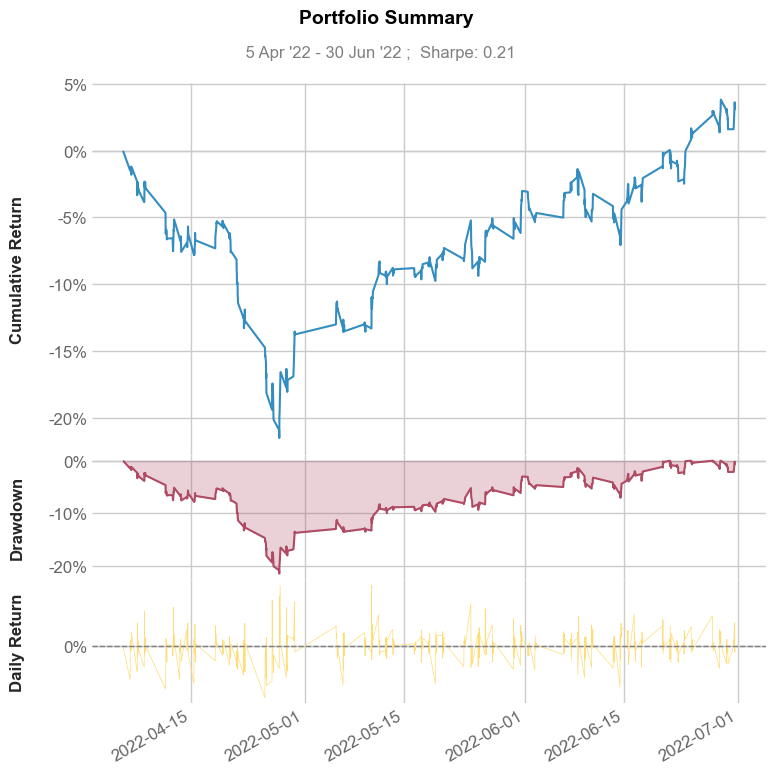

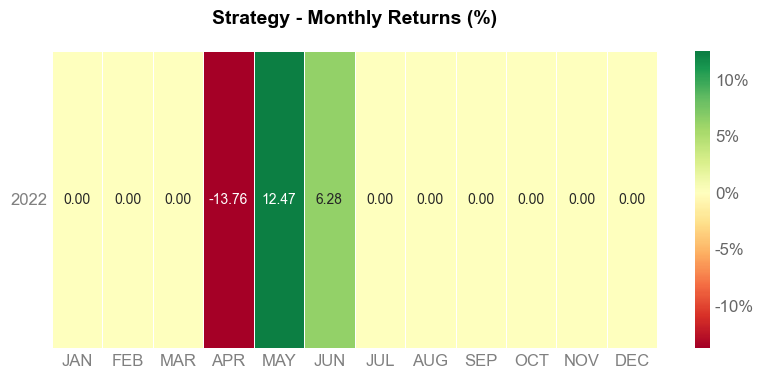

In [23]:
#Feature 1 - SMA 

#create insample and outsample data
p1 = '20220630150000000'
p2 = '20220701100000000'
feature = 'sma_mean'
upper = 'sma_upper_band'
lower = 'sma_lower_band'
insample, outsample = select_backtest_samples(data_final,p1,p2,feature, upper , lower)

#simulate using backtesting code
fund_value, total_amt_invested, cash_from_selling, periodic_trades, live_stock_inventory = backtest(insample,backtest_timeperiod_insample,lowerband=lower,upperband=upper)
#save results in a dataframe
backtest_insample_results = pd.DataFrame({'fund_value':fund_value,
                                          'total_amt_invested':total_amt_invested,
                                          'cash_from_selling':cash_from_selling,
                                          }, index=datetime_index)
backtest_insample_results.index.name = 'time'
#calculate periodic returns from results of simulation
returns = calculate_periodic_returns(backtest_insample_results)
qs.reports.basic(returns['periodic_R'])

Backtesting Progress: 100%|██████████| 472/472 [00:07<00:00, 65.89it/s]


                    Strategy
------------------  ----------
Start Period        2022-04-06
End Period          2022-06-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   9.06%
CAGR﹪              29.3%

Sharpe              0.52
Prob. Sharpe Ratio  76.0%
Sortino             0.77
Sortino/√2          0.54
Omega               1.1

Max Drawdown        -16.96%
Longest DD Days     49

Gain/Pain Ratio     0.24
Gain/Pain (1M)      2.27

Payoff Ratio        0.94
Profit Factor       1.1
Common Sense Ratio  1.11
CPC Index           0.56
Tail Ratio          1.01
Outlier Win Ratio   4.55
Outlier Loss Ratio  3.56

MTD                 6.32%
3M                  9.06%
6M                  9.06%
YTD                 9.06%
1Y                  9.06%
3Y (ann.)           29.3%
5Y (ann.)           29.3%
10Y (ann.)          29.3%
All-time (ann.)     29.3%

Avg. Drawdown       -3.2%
Avg. Drawdown Days  8
Recovery Factor     0.57
Ulcer Index         0.05
Serenity Index      0.14


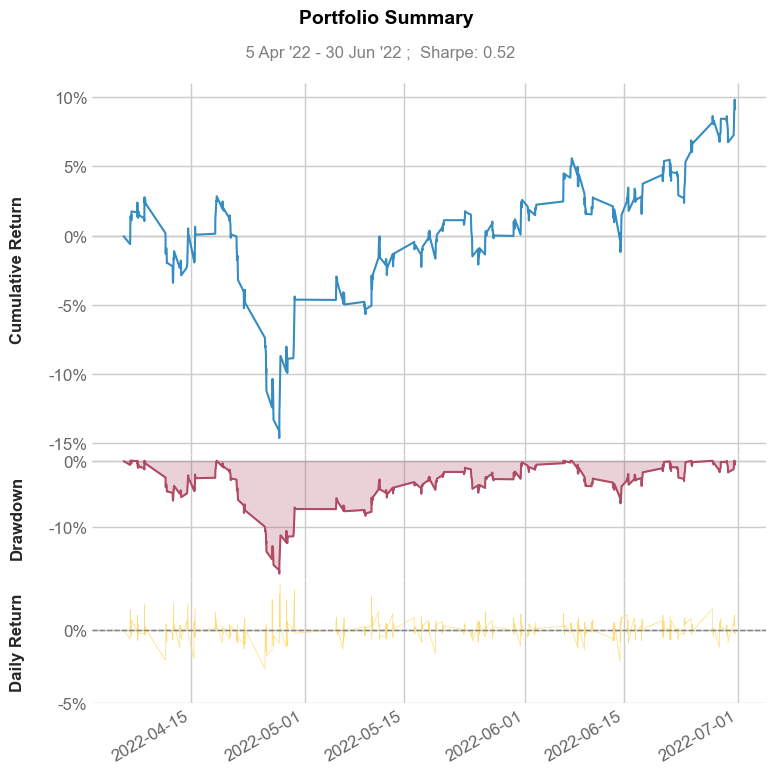

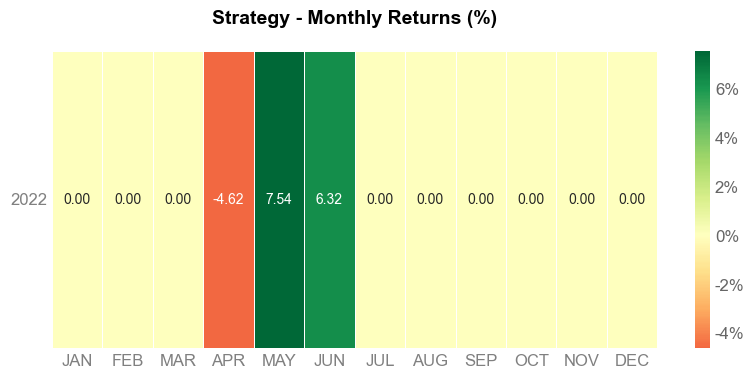

In [24]:
#Feature 2 - EMA 

#create insample and outsample data
p1 = '20220630150000000'
p2 = '20220701100000000'
feature = 'ema_mean'
upper = 'ema_upper_band'
lower = 'ema_lower_band'
insample, outsample = select_backtest_samples(data_final,p1,p2,feature, upper , lower)

#simulate using backtesting code
fund_value, total_amt_invested, cash_from_selling, periodic_trades, live_stock_inventory = backtest(insample,backtest_timeperiod_insample,lowerband=lower,upperband=upper)
#save results in a dataframe
backtest_insample_results = pd.DataFrame({'fund_value':fund_value,
                                          'total_amt_invested':total_amt_invested,
                                          'cash_from_selling':cash_from_selling,
                                          }, index=datetime_index)
backtest_insample_results.index.name = 'time'
#calculate periodic returns from results of simulation
returns = calculate_periodic_returns(backtest_insample_results)
qs.reports.basic(returns['periodic_R'])

Backtesting Progress: 100%|██████████| 472/472 [00:07<00:00, 66.71it/s]


                    Strategy
------------------  ----------
Start Period        2022-04-06
End Period          2022-06-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   11.79%
CAGR﹪              39.14%

Sharpe              0.65
Prob. Sharpe Ratio  81.14%
Sortino             0.95
Sortino/√2          0.67
Omega               1.12

Max Drawdown        -16.57%
Longest DD Days     49

Gain/Pain Ratio     0.31
Gain/Pain (1M)      2.66

Payoff Ratio        0.96
Profit Factor       1.12
Common Sense Ratio  1.05
CPC Index           0.58
Tail Ratio          0.94
Outlier Win Ratio   4.55
Outlier Loss Ratio  3.62

MTD                 10.44%
3M                  11.79%
6M                  11.79%
YTD                 11.79%
1Y                  11.79%
3Y (ann.)           39.14%
5Y (ann.)           39.14%
10Y (ann.)          39.14%
All-time (ann.)     39.14%

Avg. Drawdown       -2.02%
Avg. Drawdown Days  5
Recovery Factor     0.73
Ulcer Index         0.05
Serenity Index      0

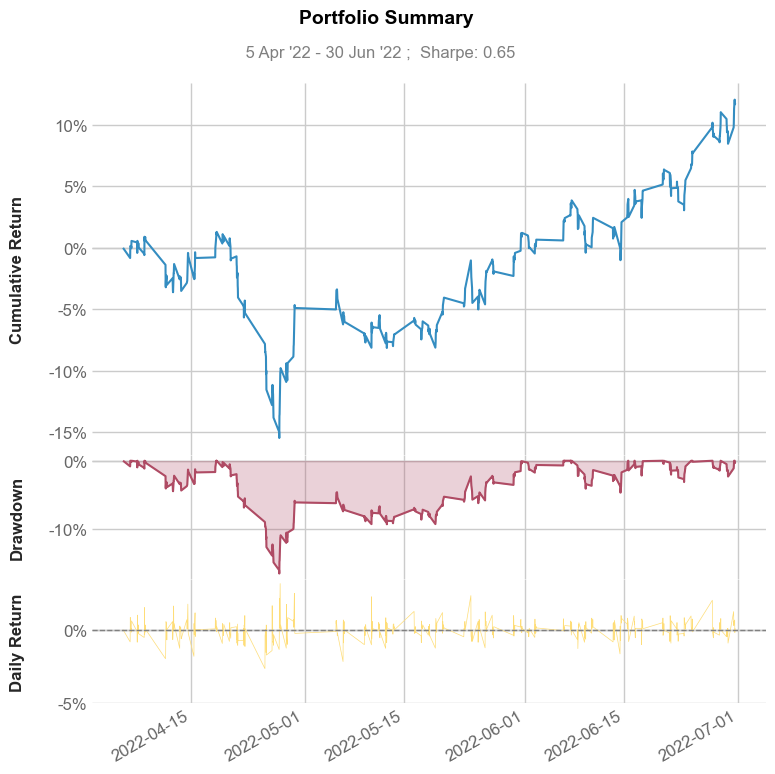

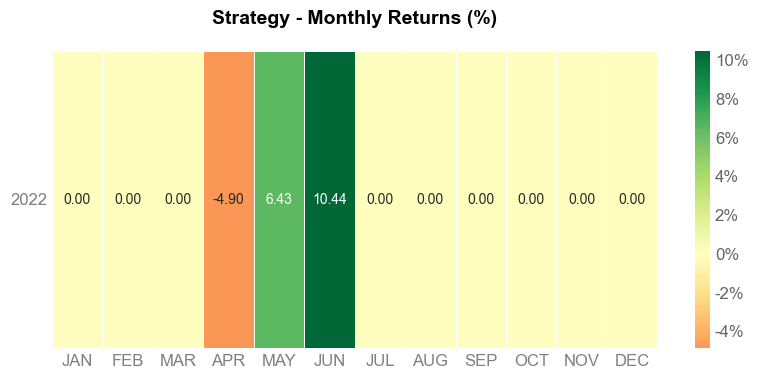

In [25]:
#Feature 3 - VWAP 

#create insample and outsample data
p1 = '20220630150000000'
p2 = '20220701100000000'
feature = 'vwap'
upper = 'vwap_upper_band'
lower = 'vwap_lower_band'
insample, outsample = select_backtest_samples(data_final,p1,p2,feature, upper , lower)

#simulate using backtesting code
fund_value, total_amt_invested, cash_from_selling, periodic_trades, live_stock_inventory = backtest(insample,backtest_timeperiod_insample,lowerband=lower,upperband=upper)
#save results in a dataframe
backtest_insample_results = pd.DataFrame({'fund_value':fund_value,
                                          'total_amt_invested':total_amt_invested,
                                          'cash_from_selling':cash_from_selling,
                                          }, index=datetime_index)
backtest_insample_results.index.name = 'time'
#calculate periodic returns from results of simulation
returns = calculate_periodic_returns(backtest_insample_results)
qs.reports.basic(returns['periodic_R'])

## Thank You! :)